In [25]:
from __future__ import division
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input, Lambda, Reshape
from keras import backend as K
from keras.optimizers import SGD, Nadam
from keras import layers

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

import os

In [26]:
DATA_DIR = os.path.abspath('./')
CHECKPOINTED_WEIGHTS = os.path.join(DATA_DIR, 'checkpointed_weights.hdf5')
INIT_WEIGHTS = os.path.join(DATA_DIR, 'init_weights_base.hdf5')
EXPERIENCE_BUFFER_FILE = os.path.join(DATA_DIR, 'experience_buffer.p')

In [27]:
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2, l1
from keras.initializers import VarianceScaling

kernel_initializer = VarianceScaling(scale=0.01, mode='fan_avg', distribution='uniform', seed=42)

def dense_relu_bn_dropout(x, size, dropout, alpha = 0.1, reg = 0):
    x = Dense(size, kernel_regularizer = l2(reg), kernel_initializer=kernel_initializer)(x)
    x = Activation('tanh')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(dropout)(x)
    return x

def create_network(reg, dropout, alpha = 0.1):
    inputs = Input(shape=(INPUT_SHAPE,), name="x")
    x = dense_relu_bn_dropout(inputs, 4 , dropout, reg)
#     x = dense_relu_bn_dropout(x, 8, dropout, reg)
    x = Dense(1, kernel_initializer=kernel_initializer)(x)
    base_network = Model(inputs=inputs, outputs = x)
    print(base_network.summary())
    return base_network

In [28]:
INPUT_SHAPE = 8
base_network = create_network(reg = 0.5, dropout = 0.5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 36        
_________________________________________________________________
activation_4 (Activation)    (None, 4)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
BASE_WEIGHTS = base_network.get_weights()
for i in xrange(len(BASE_WEIGHTS)):
    BASE_WEIGHTS[i].fill(0)
    if i == 0:
        BASE_WEIGHTS[i][:2, 0] = 1
    elif i == 2:
        BASE_WEIGHTS[i][0, 0] = 1

In [30]:
weights_to_set =base_network.get_weights()
weights_to_set[0][:2, 0] = 1
weights_to_set[2][0, 0] = 1
base_network.set_weights(weights_to_set)
base_network.get_weights()

[array([[  1.00000000e+00,   2.50892416e-02,   4.17643115e-02,
           3.61730084e-02],
        [  1.00000000e+00,   1.85282975e-02,  -4.44034263e-02,
          -5.45451194e-02],
        [ -2.31617354e-02,   3.15843448e-02,  -3.97111699e-02,
           5.05351722e-02],
        [  4.58092615e-02,   1.34933963e-02,  -7.02916905e-02,
          -3.57435793e-02],
        [  8.58999789e-04,  -1.95743106e-02,  -6.43695667e-02,
           6.67743608e-02],
        [  4.64411452e-02,  -1.20796412e-02,   1.43777430e-02,
          -2.26858445e-02],
        [  1.03382841e-02,  -3.72991040e-02,   2.47182697e-02,
          -6.96754530e-02],
        [ -6.77531883e-02,   6.53196499e-02,   1.90216154e-02,
          -3.87078039e-02]], dtype=float32),
 array([ 0.,  0.,  0.,  0.], dtype=float32),
 array([[ 1.        ],
        [ 0.03886809],
        [ 0.06470098],
        [ 0.05603898]], dtype=float32),
 array([ 0.], dtype=float32)]

In [47]:
from keras import layers
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input, Lambda, Reshape

input_a = Input(shape=(INPUT_SHAPE,))
processed_a = base_network(input_a)
input_b = Input(shape=(INPUT_SHAPE,))
processed_b = base_network(input_b)
distance = layers.Subtract()([processed_a, processed_b])
out = Activation('sigmoid')(distance)
siamese_net = Model([input_a, input_b], out)
siamese_net.save_weights(INIT_WEIGHTS)
print(siamese_net.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 8)             0                                            
____________________________________________________________________________________________________
input_6 (InputLayer)             (None, 8)             0                                            
____________________________________________________________________________________________________
model_4 (Model)                  (None, 1)             41          input_5[0][0]                    
                                                                   input_6[0][0]                    
____________________________________________________________________________________________________
subtract_3 (Subtract)            (None, 1)             0           model_4[3][0]           

In [48]:
import cPickle as pickle
MOVES = pickle.load(open("../moves_dict.p", "rb"))

In [59]:
key = 'Five_Minute_Championship_Player-game-138#12#4.gcg'
l = MOVES[key]
for i in l:
    print(i)
# for file in MOVES:
#     print(file)
#     for k in MOVES[file]:
#         print(k)
#     break

[27.0, 4.19921875, 352.385009765625, 1.1437000036239624, 0.0, 1.350000023841858, -1.0, 0.0]
[23.0, 4.02734375, 258.0719909667969, 1.8662999868392944, -3.0799999237060547, 1.2899999618530273, -0.5, 0.0]
[34.0, 1.359375, 201.1909942626953, 0.05119999870657921, 0.0, -0.3400000035762787, 0.0, 0.0]
[27.0, 1.7265625, 299.5270080566406, 0.25929999351501465, 0.0, 1.149999976158142, -1.0, 0.0]
[26.0, -2.421875, 131.0500030517578, 0.31049999594688416, -4.340000152587891, 1.2899999618530273, -0.5, 0.0]
[14.0, 8.1171875, 416.8240051269531, 0.7738000154495239, 0.0, 1.2899999618530273, 0.5, 0.0]
[14.0, 8.1171875, 416.8240051269531, 0.7738000154495239, 0.0, 1.2899999618530273, 0.5, 0.0]
[22.0, 1.359375, 201.1909942626953, 0.05119999870657921, 0.0, -0.3400000035762787, 0.0, 0.0]
[22.0, -2.79296875, 145.26699829101562, 0.6291999816894531, 0.0, 0.5799999833106995, -3.5, 0.0]


In [34]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5,
              patience=5, verbose = 1, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_acc',
                              min_delta=5e-4,
                              patience=20,
                              verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath=CHECKPOINTED_WEIGHTS, verbose=1, save_best_only=True, monitor='val_acc')

In [51]:
import utils; reload(utils)
from utils import DataGenerator

BATCH_SIZE = 512
maxlen = 4
EXPERIENCE_BUFFER_FILE = "experience_buffer/experience_buffer_len{}.p".format(maxlen) 
load_from_file = False #os.path.exists(EXPERIENCE_BUFFER_FILE)
save_to_file = not load_from_file
datagen = DataGenerator(MOVES, batch_sz = BATCH_SIZE, load_from_file = load_from_file, 
                 save_to_file = save_to_file, maxlen = maxlen, file = EXPERIENCE_BUFFER_FILE)

Experience buffer generated
Experience buffer saved to experience_buffer/experience_buffer_len4.p
Train: 443639 Val: 18485


In [53]:
nadam = Nadam(lr=1e-3)
siamese_net.compile(optimizer=nadam, loss='binary_crossentropy', metrics=['accuracy'])
siamese_net.load_weights(INIT_WEIGHTS)

In [37]:
NUM_TRAIN_PAIRS, NUM_VAL_PAIRS = datagen.get_num_pairs()
STEPS_PER_EPOCH = NUM_TRAIN_PAIRS//BATCH_SIZE
VALIDATION_STEPS = NUM_VAL_PAIRS//BATCH_SIZE

In [33]:
history = siamese_net.fit_generator(
        datagen.next_train(),
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=500,
        validation_data=datagen.next_val(),
        validation_steps=VALIDATION_STEPS,
        callbacks = [reduce_lr, checkpointer, early_stopping])

Epoch 1/500
130/130 [==============================] - 0s - loss: 0.6921 - acc: 0.4960 - val_loss: 0.6911 - val_acc: 0.4963
Epoch 2/500
130/130 [==============================] - 0s - loss: 0.6877 - acc: 0.5247 - val_loss: 0.6864 - val_acc: 0.5297
Epoch 3/500
130/130 [==============================] - 0s - loss: 0.6832 - acc: 0.5510 - val_loss: 0.6800 - val_acc: 0.5406
Epoch 4/500
130/130 [==============================] - 0s - loss: 0.6775 - acc: 0.5692 - val_loss: 0.6736 - val_acc: 0.5559
Epoch 5/500
130/130 [==============================] - 0s - loss: 0.6721 - acc: 0.5772 - val_loss: 0.6690 - val_acc: 0.6028
Epoch 6/500
130/130 [==============================] - 0s - loss: 0.6674 - acc: 0.5825 - val_loss: 0.6639 - val_acc: 0.5778
Epoch 7/500
130/130 [==============================] - 0s - loss: 0.6633 - acc: 0.5854 - val_loss: 0.6606 - val_acc: 0.6037
Epoch 8/500
130/130 [==============================] - 0s - loss: 0.6599 - acc: 0.5876 - val_loss: 0.6558 - val_acc: 0.5997
Epoch 9/

KeyboardInterrupt: 

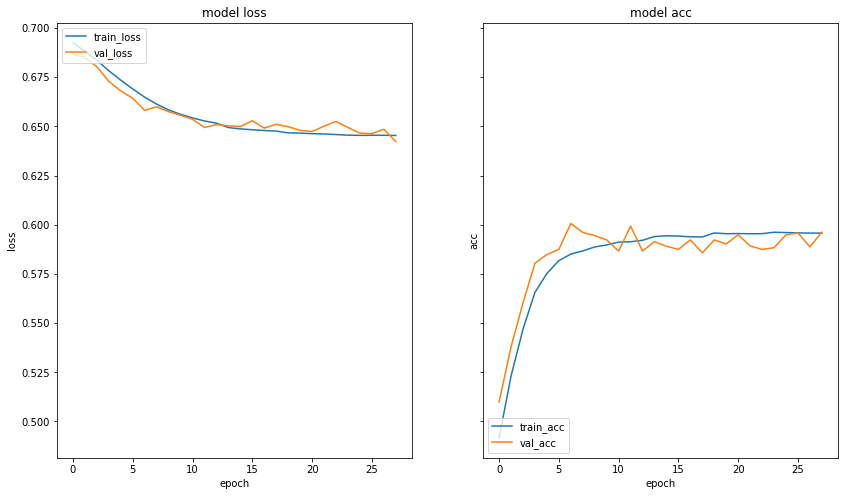

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(8)
f.set_figwidth(14)

ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train_loss', 'val_loss'], loc='upper left')

ax2.plot(history.history['acc'])
ax2.plot(history.history['val_acc'])
ax2.set_title('model acc')
ax2.set_ylabel('acc')
ax2.set_xlabel('epoch')
ax2.legend(['train_acc', 'val_acc'], loc='lower left')

plt.show()

In [54]:
for i in range(2):
    if i == 0:
        print("Base weights:")
        siamese_net.set_weights(BASE_WEIGHTS)
    else:
        print("Checkpointed weights:")
        siamese_net.load_weights(CHECKPOINTED_WEIGHTS)
    val = siamese_net.evaluate_generator(
            datagen.next_train(),
            steps=STEPS_PER_EPOCH)
    print("Loss: {} Acc: {}".format(val[0], val[1]))

Base weights:
Loss: 0.692293151984 Acc: 0.0571063701923
Checkpointed weights:
Loss: 0.504838728446 Acc: 0.771649639423


In [ ]:
siamese_net.set_weights(BASE_WEIGHTS)
# siamese_net.load_weights(CHECKPOINTED_WEIGHTS)
SAVE_MODEL = "keras_tensorflow"
model_to_save = siamese_net.layers[2]
model_to_save.summary()
model_to_save.save(SAVE_MODEL, overwrite='True')

In [ ]:
model_to_save.get_weights()